PHÂN CỤM DỮ LIỆU CHO BÀI TOÁN PHÂN LOẠI DƯA TRÊN CÁC MA TRẬN TF-IDF

- Mô hình K-MEANS cho dữ liệu ban đầu chưa áp dụng giảm chiều

In [ ]:
# Tải dữ liệu từ link drive
!pip install -q gdown
import gdown

# Link chứa data tfidf_vectors.csv
file_id1 = '1TfqQkSbreV6Sbj3N-nwexeHqlV01c-fX'
url1 = f'https://drive.google.com/uc?id={file_id1}'
output1 = 'tfidf_vectors.csv'

# Link chứa data đã xử lí processed_data.csv
file_id2 = '1UNOXZTOun0lFV9tI4Bip8TlEb191GjMS'
url2 = f'https://drive.google.com/uc?id={file_id2}'
output2 = 'processed_data.csv'

# Tải các file trên
gdown.download(url1, output1, quiet=False)
gdown.download(url2, output2, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1TfqQkSbreV6Sbj3N-nwexeHqlV01c-fX
From (redirected): https://drive.google.com/uc?id=1TfqQkSbreV6Sbj3N-nwexeHqlV01c-fX&confirm=t&uuid=14f1589e-b27a-4269-8db8-23b000e70148
To: /content/tfidf_vectors.csv
100%|██████████| 522M/522M [00:07<00:00, 66.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1UNOXZTOun0lFV9tI4Bip8TlEb191GjMS
From (redirected): https://drive.google.com/uc?id=1UNOXZTOun0lFV9tI4Bip8TlEb191GjMS&confirm=t&uuid=a0887e4f-68bb-42fe-a0c1-e1b87228b09f
To: /content/processed_data.csv
100%|██████████| 130M/130M [00:01<00:00, 119MB/s]


'processed_data.csv'

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import scipy.sparse as sp

In [ ]:
# Hàm xử lý dữ liệu từ processed_data.csv và tfidf_vectors.csv, lưu dữ liệu giảm chiều
def preprocess_from_csv_and_save():
    # Tải dữ liệu từ processed_data.csv
    try:
        df = pd.read_csv(output2)
        print("Đã tải dữ liệu từ 'processed_data.csv'")
    except FileNotFoundError:
        print("File 'processed_data.csv' không tồn tại. Vui lòng chạy download_data() trước.")
        return

    # Tải ma trận TF-IDF từ tfidf_vectors.csv
    try:
        tfidf_full = pd.read_csv(output1).to_numpy()
        print("Đã tải ma trận TF-IDF từ 'tfidf_vectors.csv'")
    except FileNotFoundError:
        print("File 'tfidf_vectors.csv' không tồn tại. Vui lòng chạy download_data() trước.")
        return

    # Chuẩn bị dữ liệu
    numeric_cols = ['num_helpful_votes', 'hotel_class', 'price_per_night']
    X = df[numeric_cols + ['text']]
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Chọn hàng TF-IDF tương ứng với tập train
    train_indices = X_train.index
    tfidf_train = tfidf_full[train_indices]

    # Tính TF-IDF cho tập test
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
    tfidf.fit(X_train['text'])  # Fit trên tập train để đảm bảo từ vựng khớp
    tfidf_test = tfidf.transform(X_test['text'])

    # Kiểm tra kích thước
    print(f"Kích thước X_train[numeric_cols]: {X_train[numeric_cols].to_numpy().shape}")
    print(f"Kích thước tfidf_train: {tfidf_train.shape}")
    print(f"Kích thước X_test[numeric_cols]: {X_test[numeric_cols].to_numpy().shape}")
    print(f"Kích thước tfidf_test: {tfidf_test.toarray().shape}")

    # Kết hợp đặc trưng số và TF-IDF
    X_train_combined = np.hstack([X_train[numeric_cols].to_numpy(), tfidf_train])
    X_test_combined = np.hstack([X_test[numeric_cols].to_numpy(), tfidf_test.toarray()])

    # Giảm chiều với PCA
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_combined)
    X_test_pca = pca.transform(X_test_combined)
    scaler_pca = StandardScaler()
    X_train_pca_scaled = scaler_pca.fit_transform(X_train_pca)
    X_test_pca_scaled = scaler_pca.transform(X_test_pca)
    print(f"Số chiều sau PCA: {X_train_pca.shape[1]}")
    print(f"Tổng phương sai bảo tồn (PCA): {sum(pca.explained_variance_ratio_):.2%}")

    # Giảm chiều với TruncatedSVD
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_train_svd = svd.fit_transform(sp.hstack([sp.csr_matrix(X_train[numeric_cols]), sp.csr_matrix(tfidf_train)]))
    X_test_svd = svd.transform(sp.hstack([sp.csr_matrix(X_test[numeric_cols]), tfidf_test]))
    scaler_svd = StandardScaler()
    X_train_svd_scaled = scaler_svd.fit_transform(X_train_svd)
    X_test_svd_scaled = scaler_svd.transform(X_test_svd)
    print(f"Số chiều sau TruncatedSVD: {X_train_svd.shape[1]}")
    print(f"Tổng phương sai bảo tồn (SVD): {sum(svd.explained_variance_ratio_):.2%}")

    # Lưu dữ liệu đã xử lý
    processed_data = {
        'X_train_combined': X_train_combined,
        'X_test_combined': X_test_combined,
        'X_train_pca_scaled': X_train_pca_scaled,
        'X_test_pca_scaled': X_test_pca_scaled,
        'X_train_svd_scaled': X_train_svd_scaled,
        'X_test_svd_scaled': X_test_svd_scaled,
        'y_train': y_train,
        'y_test': y_test
    }
    with open('processed_data.pkl', 'wb') as f:
        pickle.dump(processed_data, f)
    print("Đã lưu dữ liệu giảm chiều vào 'processed_data.pkl'")

In [ ]:
# Hàm tải dữ liệu đã xử lý
def load_processed_data():
    try:
        with open('processed_data.pkl', 'rb') as f:
            data = pickle.load(f)
        print("Đã tải dữ liệu từ 'processed_data.pkl'")
        return (data['X_train_combined'], data['X_test_combined'],
                data['X_train_pca_scaled'], data['X_test_pca_scaled'],
                data['X_train_svd_scaled'], data['X_test_svd_scaled'],
                data['y_train'], data['y_test'])
    except FileNotFoundError:
        print("File 'processed_data.pkl' không tồn tại. Vui lòng chạy preprocess_from_csv_and_save() trước.")
        return None

In [ ]:
# Hàm đánh giá phân cụm
def evaluate_clustering(X, labels, true_labels, method_name):
    sil_score = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    ari_score = adjusted_rand_score(true_labels, labels)
    nmi_score = normalized_mutual_info_score(true_labels, labels)
    print(f"\nĐánh giá {method_name}:")
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
    return sil_score, ari_score, nmi_score

In [ ]:
# Hàm trực quan hóa cụm
def plot_clusters(X, labels, true_labels, title, dim_reduced=True):
    plt.figure(figsize=(10, 6))
    if dim_reduced:
        scatter = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, style=true_labels,
                                 palette='deep', legend='full', alpha=0.6)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
    else:
        scatter = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, style=true_labels,
                                 palette='deep', legend='full', alpha=0.6)
        plt.title(title)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()

Đã tải dữ liệu từ 'processed_data.csv'
Đã tải ma trận TF-IDF từ 'tfidf_vectors.csv'
Kích thước X_train[numeric_cols]: (90319, 3)
Kích thước tfidf_train: (90319, 1000)
Kích thước X_test[numeric_cols]: (22580, 3)
Kích thước tfidf_test: (22580, 1000)
Số chiều sau PCA: 656
Tổng phương sai bảo tồn (PCA): 95.00%
Số chiều sau TruncatedSVD: 100
Tổng phương sai bảo tồn (SVD): 76.48%
Đã lưu dữ liệu giảm chiều vào 'processed_data.pkl'
Đã tải dữ liệu từ 'processed_data.pkl'
=== K-Means Clustering ===

Đánh giá K-Means (Original):
Silhouette Score: 0.2752
Adjusted Rand Index (ARI): 0.0070
Normalized Mutual Information (NMI): 0.0076


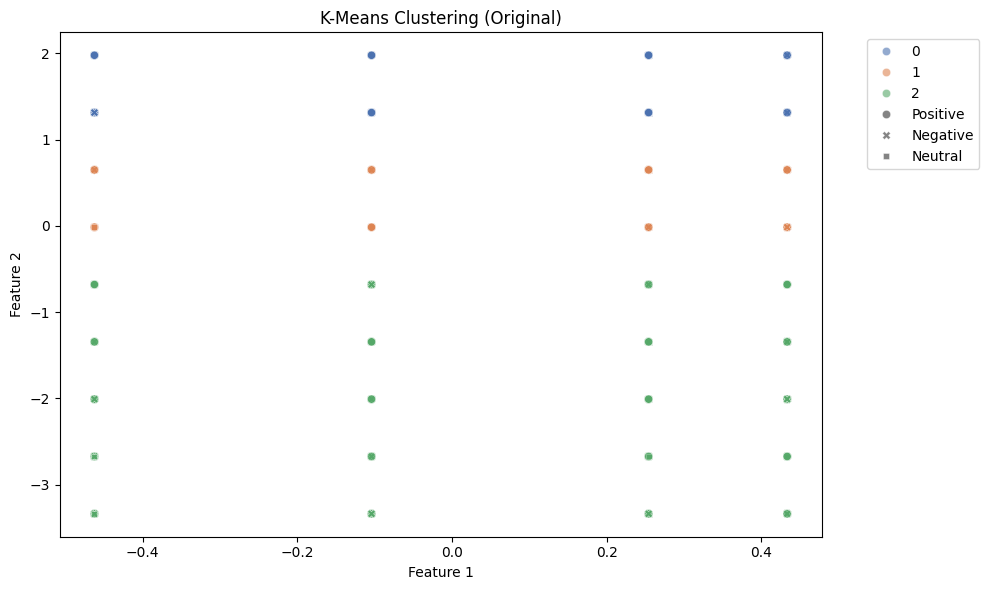


Đánh giá K-Means (PCA):
Silhouette Score: -0.0003
Adjusted Rand Index (ARI): -0.0036
Normalized Mutual Information (NMI): 0.0070


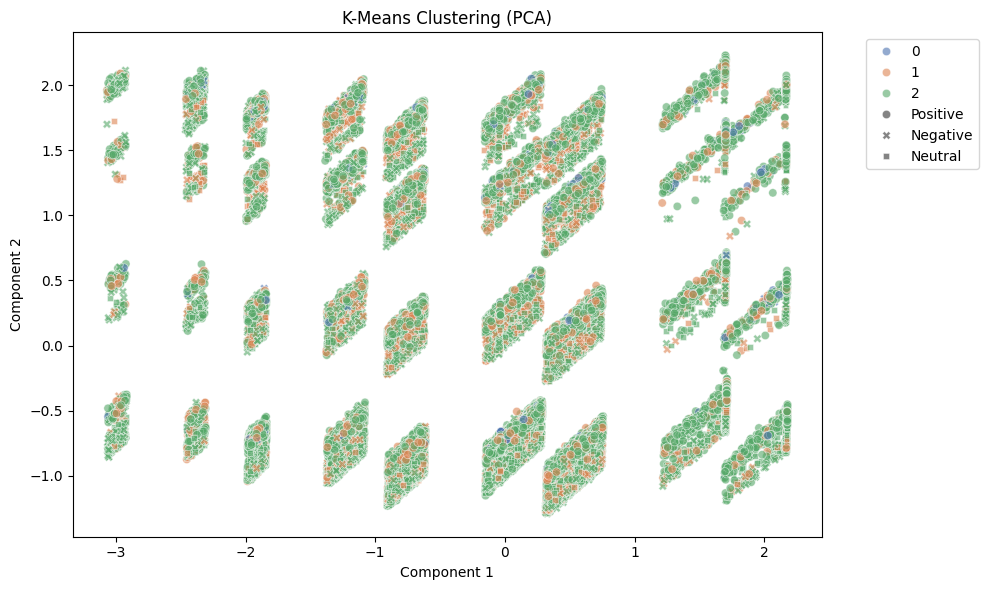


Đánh giá K-Means (SVD):
Silhouette Score: 0.0170
Adjusted Rand Index (ARI): -0.0601
Normalized Mutual Information (NMI): 0.0328


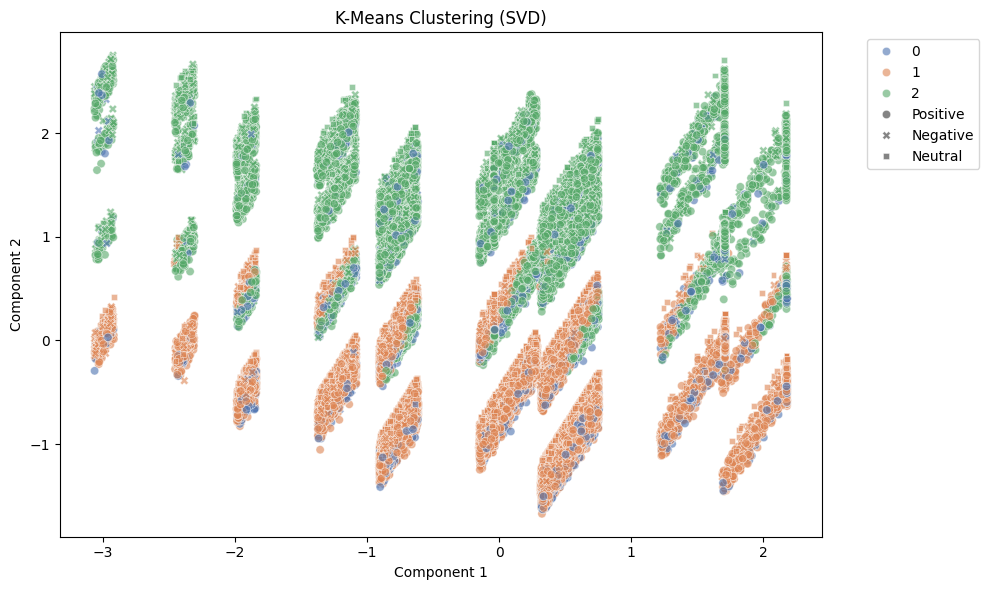


=== GMM Clustering ===

Đánh giá GMM (Original):
Silhouette Score: -0.0023
Adjusted Rand Index (ARI): 0.1927
Normalized Mutual Information (NMI): 0.2154


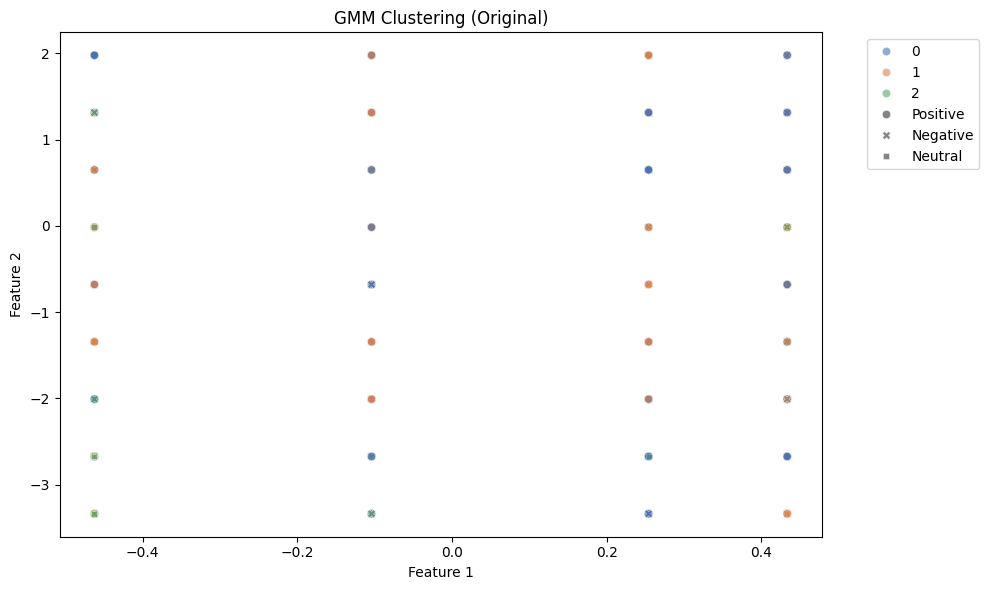


Đánh giá GMM (PCA):
Silhouette Score: -0.0708
Adjusted Rand Index (ARI): 0.4152
Normalized Mutual Information (NMI): 0.2370


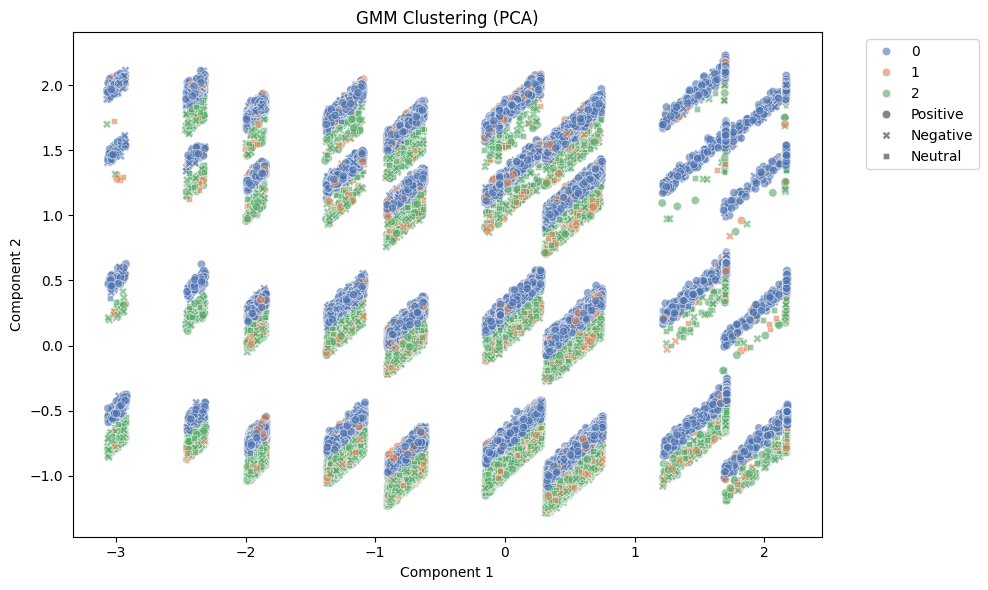


Đánh giá GMM (SVD):
Silhouette Score: -0.0291
Adjusted Rand Index (ARI): 0.3382
Normalized Mutual Information (NMI): 0.2347


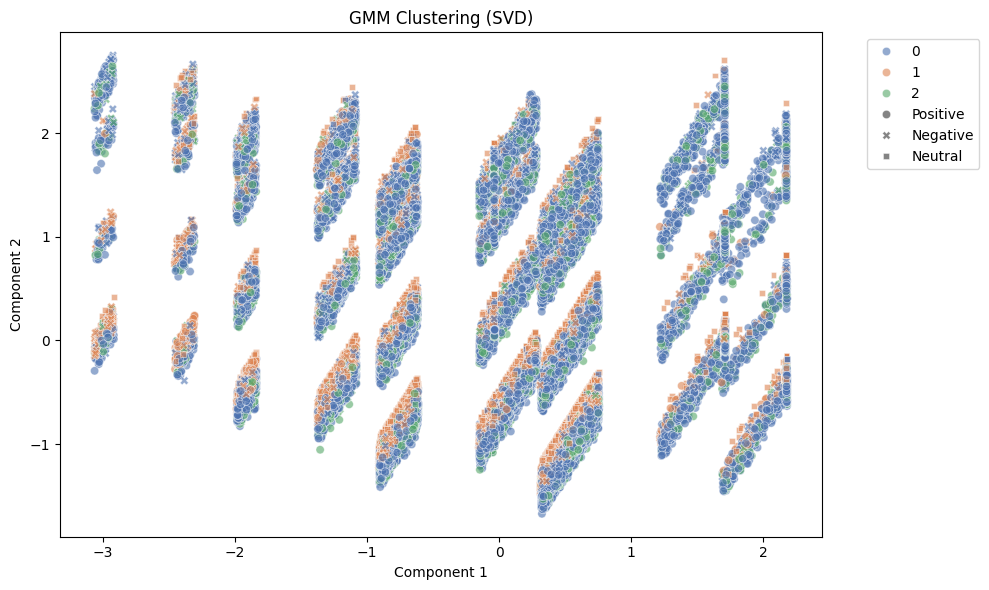


Phân phối nhãn Sentiment trong các cụm (K-Means (Original)):
Sentiment  Negative  Neutral  Positive
Cluster                               
0              1247      483      7754
1              8450     3627     37584
2              7259     3067     20848

Phân phối nhãn Sentiment trong các cụm (K-Means (PCA)):
Sentiment  Negative  Neutral  Positive
Cluster                               
0               409       11      1596
1              2859     2286     14545
2             13688     4880     50045

Phân phối nhãn Sentiment trong các cụm (K-Means (SVD)):
Sentiment  Negative  Neutral  Positive
Cluster                               
0               746       33      7924
1             11660     6431     36935
2              4550      713     21327

Phân phối nhãn Sentiment trong các cụm (GMM (Original)):
Sentiment  Negative  Neutral  Positive
Cluster                               
0              4763      337     31394
1              3342      187     30154
2              8851     6

In [ ]:
# Hàm phân tích mối quan hệ giữa cụm và nhãn sentiment
def analyze_cluster_label_relation(labels, true_labels, method_name):
    cluster_label_df = pd.DataFrame({'Cluster': labels, 'Sentiment': true_labels})
    crosstab = pd.crosstab(cluster_label_df['Cluster'], cluster_label_df['Sentiment'])
    print(f"\nPhân phối nhãn Sentiment trong các cụm ({method_name}):")
    print(crosstab)

# Main execution
if __name__ == "__main__":
    # Xử lý từ processed_data.csv và tfidf_vectors.csv, lưu dữ liệu giảm chiều (chỉ chạy lần đầu)
    preprocess_from_csv_and_save()

    # Tải dữ liệu đã xử lý
    data = load_processed_data()
    if data is None:
        print("Vui lòng chạy preprocess_from_csv_and_save() trước.")
    else:
        (X_train_combined, X_test_combined, X_train_pca_scaled, X_test_pca_scaled,
         X_train_svd_scaled, X_test_svd_scaled, y_train, y_test) = data

        # Số cụm
        n_clusters = 3

        # 1. K-Means Clustering
        print("=== K-Means Clustering ===")
        # Original
        kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels_orig = kmeans_orig.fit_predict(X_train_combined)
        evaluate_clustering(X_train_combined, kmeans_labels_orig, y_train, "K-Means (Original)")
        plot_clusters(X_train_combined, kmeans_labels_orig, y_train, "K-Means Clustering (Original)", dim_reduced=False)

        # PCA
        kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels_pca = kmeans_pca.fit_predict(X_train_pca_scaled)
        evaluate_clustering(X_train_pca_scaled, kmeans_labels_pca, y_train, "K-Means (PCA)")
        plot_clusters(X_train_pca_scaled, kmeans_labels_pca, y_train, "K-Means Clustering (PCA)")

        # SVD
        kmeans_svd = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels_svd = kmeans_svd.fit_predict(X_train_svd_scaled)
        evaluate_clustering(X_train_svd_scaled, kmeans_labels_svd, y_train, "K-Means (SVD)")
        plot_clusters(X_train_svd_scaled, kmeans_labels_svd, y_train, "K-Means Clustering (SVD)")

        # 2. GMM Clustering
        print("\n=== GMM Clustering ===")
        # Original
        gmm_orig = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm_labels_orig = gmm_orig.fit_predict(X_train_combined)
        evaluate_clustering(X_train_combined, gmm_labels_orig, y_train, "GMM (Original)")
        plot_clusters(X_train_combined, gmm_labels_orig, y_train, "GMM Clustering (Original)", dim_reduced=False)

        # PCA
        gmm_pca = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm_labels_pca = gmm_pca.fit_predict(X_train_pca_scaled)
        evaluate_clustering(X_train_pca_scaled, gmm_labels_pca, y_train, "GMM (PCA)")
        plot_clusters(X_train_pca_scaled, gmm_labels_pca, y_train, "GMM Clustering (PCA)")

        # SVD
        gmm_svd = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm_labels_svd = gmm_svd.fit_predict(X_train_svd_scaled)
        evaluate_clustering(X_train_svd_scaled, gmm_labels_svd, y_train, "GMM (SVD)")
        plot_clusters(X_train_svd_scaled, gmm_labels_svd, y_train, "GMM Clustering (SVD)")

        # Phân tích mối quan hệ
        analyze_cluster_label_relation(kmeans_labels_orig, y_train, "K-Means (Original)")
        analyze_cluster_label_relation(kmeans_labels_pca, y_train, "K-Means (PCA)")
        analyze_cluster_label_relation(kmeans_labels_svd, y_train, "K-Means (SVD)")
        analyze_cluster_label_relation(gmm_labels_orig, y_train, "GMM (Original)")
        analyze_cluster_label_relation(gmm_labels_pca, y_train, "GMM (PCA)")
        analyze_cluster_label_relation(gmm_labels_svd, y_train, "GMM (SVD)")